In [ ]:
from tensorflow.keras import backend as K
K.clear_session()

In [ ]:
!pip install rarfile

In [ ]:
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image
# Download the RAR file
url = 'https://drive.google.com/uc?id=1rHAHyhvr_0adToHaxvSaWgPa3h3PPvoO'
output_rar = '/content/Dataset_CT-Scan.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')

Downloading...
From: https://drive.google.com/uc?id=1rHAHyhvr_0adToHaxvSaWgPa3h3PPvoO
To: /content/Dataset_CT-Scan.rar
100%|██████████| 9.03M/9.03M [00:00<00:00, 55.0MB/s]


In [ ]:
# Path to the extracted dataset folder

dataset = '/content/Dataset_CT-Scan'

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, BatchNormalization, Add, AveragePooling2D, Flatten, Dense

def conv_block(inputs, filters, kernel_size, strides=(1, 1)):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters=filters[2], kernel_size=(1, 1), strides=strides, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def identity_block(inputs, filters):
    x = Conv2D(filters=filters[0], kernel_size=(1, 1), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[1], kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filters[2], kernel_size=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, inputs])
    x = Activation('relu')(x)
    return x

def resnet_50():
    inputs = Input(shape=(224, 224, 3))

    # Initial layers
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], (3, 3))
    for _ in range(2):
        x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], (3, 3), strides=(2, 2))
    for _ in range(3):
        x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], (3, 3), strides=(2, 2))
    for _ in range(5):
        x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048], (3, 3), strides=(2, 2))
    for _ in range(2):
        x = identity_block(x, [512, 512, 2048])

    # Final layers
    x = AveragePooling2D((7, 7))(x)
    x = Flatten()(x)
    classes=3
    outputs = Dense(classes, activation='softmax')(x)

    resnet50 = Model(inputs=inputs, outputs=outputs)
    resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return resnet50

model = resnet_50()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 56, 56, 256)    │         16,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 56, 56, 256)    │          1,024 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 56, 56, 256)    │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 256)    │              0 │ batch_normalization_3… │
│                           │                        │                │ batch_normalization_4… │
├──────────────────────

 Total params: 23,593,859 (90.00 MB)

 Trainable params: 23,540,739 (89.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

Found 767 images belonging to 3 classes.
Found 109 images belonging to 3 classes.
Found 221 images belonging to 3 classes.
Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/24 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5246 - loss: 1.0881 - val_accuracy: 0.3761 - val_loss: 1.0546
Epoch 2/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 285ms/step - accuracy: 0.8243 - loss: 0.4488 - val_accuracy: 0.3761 - val_loss: 1.1553
Epoch 3/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step - accuracy: 0.8797 - loss: 0.2990 - val_accuracy: 0.3761 - val_loss: 1.6419
Epoch 4/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 299ms/step - accuracy: 0.9411 - loss: 0.1887 - val_accuracy: 0.3761 - val_loss: 2.4390
Epoch 5/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 284ms/step - accuracy: 0.9656 - loss: 0.1171 - val_accuracy: 0.3761 - val_loss: 5.1529
Epoch 6/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.9493 - loss: 0.1629 - val_accuracy: 0.3761 - val_loss: 5.2548
Epoch 7/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 293ms/step - accuracy: 0.9705 - loss: 0.0912 - val_accuracy: 0.3761 - val_loss: 5.5848
Epoch 8/60
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 287ms/step - accuracy: 0.9677 - loss: 0.0864 - val_accuracy: 0.3761 - v

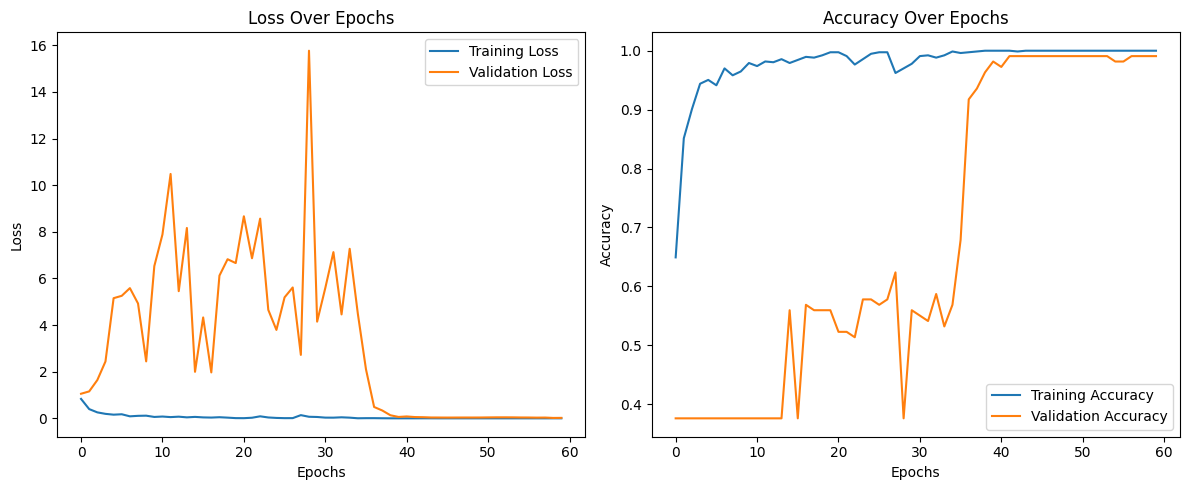

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 888ms/step

Performance on Test Data [Using Dense_Net-ReLu]
Precision: 0.9911606860991266
Recall: 0.9909502262443439
F1 Score: 0.990806725995533
Accuracy: 0.9909502262443439
Confusion Matrix:
                  Bengin cases  Malignant cases  Normal cases
Bengin cases               22                0             2
Malignant cases             0              113             0
Normal cases                0                0            84


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add,
    GlobalAveragePooling2D, Flatten, Dense
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# Directory for the dataset
data_dir = dataset

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# ImageDataGenerators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators for training, validation, and testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, 'Train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, 'Validate'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_dir, 'Test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(train_generator, epochs=60, validation_data=val_generator)

# Plot training results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Helper function to evaluate the model on given test generator
def evaluate_model(test_generator, model, classes, title="Performance"):
    y_test_pred = model.predict(test_generator)
    y_test_pred = np.argmax(y_test_pred, axis=1)

    precision = precision_score(test_generator.labels, y_test_pred, average='weighted')
    recall = recall_score(test_generator.labels, y_test_pred, average='weighted')
    f1 = f1_score(test_generator.labels, y_test_pred, average='weighted')
    accuracy = accuracy_score(test_generator.labels, y_test_pred)

    print(f"\n{title}")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Accuracy:", accuracy)

    # Display the confusion matrix
    confusion = confusion_matrix(test_generator.labels, y_test_pred)
    confusion_df = pd.DataFrame(confusion, index=classes, columns=classes)
    print("Confusion Matrix:\n", confusion_df)

# Test the model on the test set
evaluate_model(test_generator, model, ['Bengin cases','Malignant cases','Normal cases'], title="Performance on Test Data [Using ResNet-ReLu]")
